Celem jest stworzenie modelu, który posłuży do przewidzenia ceny na podstawie danych historycznych

In [1]:
import numpy
import pandas as pd
import matplotlib.pyplot as plt
from pandas import read_csv
import math
from keras.models import Sequential
from keras.layers import Dense, SimpleRNN, LSTM, Dropout, Activation
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error
from keras.callbacks import EarlyStopping
from keras.wrappers.scikit_learn import KerasClassifier

Using TensorFlow backend.


In [2]:
# zafixowanie random seed w celu powtarzalności wyników

numpy.random.seed(123)

In [3]:
# wczytanie wcześniej przygotowanych danych do dataframe

dataframe = read_csv('data\KROK_1\BTC_data.csv', usecols=[1], engine='python', skipfooter=3)

In [4]:
#określenie punktu początkowego i końcowego dla "okna" z którego zczytujemy dane

start_point = 0
stop_point = len(dataframe)
dataframe  = dataframe[start_point:stop_point]

In [5]:
# normalizacja e danych

scaler = MinMaxScaler(feature_range=(0, 1))
dataset = scaler.fit_transform(dataframe)

dataset.dtype

dtype('float64')

In [6]:
dataset.shape

(2318, 1)

In [7]:
# podział danych na treningowe i testowe

percent_split = 0.65

train_size = int(len(dataset) * percent_split)
test_size = len(dataset) - train_size
train, test = dataset[0:train_size,:], dataset[train_size:len(dataset),:]

train_size, test_size

(1506, 812)

In [8]:
train.shape, test.shape

((1506, 1), (812, 1))

In [9]:
dataset_size = len(dataset)
dataset_size

2318

In [10]:
# przekonwertowanie szeregu w macierz danych dla modelu LSTM

def create_dataset(dataset, look_back=1):
    dataX, dataY = [], []
    
    for i in range(len(dataset)-look_back-1):
        a = dataset[i:(i+look_back), 0]
        dataX.append(a)
        dataY.append(dataset[i + look_back, 0])
    
    return numpy.array(dataX), numpy.array(dataY)

In [11]:
# przekonwertowanie szeregu w macierz danych dla modelu LSTM gdzie X = Y - lookback(podziałka czasowa - 1 dzień)

look_back = 1

trainX, trainY = create_dataset(train, look_back)
testX, testY = create_dataset(test, look_back)

In [12]:
# reshape danych [samples, time steps, features]

trainX = numpy.reshape(trainX, (trainX.shape[0], 1, trainX.shape[1]))
testX = numpy.reshape(testX, (testX.shape[0], 1, testX.shape[1]))

In [13]:
from itertools import product

In [14]:
# model LSTM
# nauczanie na danych treningowych

n_no = [1,4,8,16,32,64,128] #,10,16,32,64, 128
batchsize = [1, 5, 10, 20] #, 5, 10
wyniki = []

for no_batch in batchsize:
    for il in n_no:
        model_LSTM = Sequential()
        model_LSTM.add(LSTM(il, input_shape=(1, look_back)))
        model_LSTM.add(Dropout(0.5))      
        model_LSTM.add(Dense(1))      # , activation='softmax'
        model_LSTM.compile(optimizer = 'adam', loss = 'mean_squared_error') #, metrics=['accuracy']
        print('\n','Batch size: ', no_batch)
        print('Ilość neuronów: ', il)       
        print(model_LSTM.summary())
        
        early_stopping = EarlyStopping(patience=3, monitor='val_loss')              
        model_LSTM.fit(trainX, trainY, epochs=10, batch_size=no_batch, verbose=1, validation_split=0.25, callbacks=[early_stopping])
        
        trainPredict = model_LSTM.predict(trainX)
        testPredict = model_LSTM.predict(testX)
        
        trainPredict_sc = scaler.inverse_transform(trainPredict)
        trainY_sc = scaler.inverse_transform([trainY])
        testPredict_sc = scaler.inverse_transform(testPredict)
        testY_sc = scaler.inverse_transform([testY])

        trainScore = math.sqrt(mean_squared_error(trainY_sc[0], trainPredict_sc[:,0]))
        print('Train Score: %.2f RMSE' % (trainScore))
        testScore = math.sqrt(mean_squared_error(testY_sc[0], testPredict_sc[:,0]))
        print('Test Score: %.2f RMSE' % (testScore))

        
        check_param =[il, no_batch, trainScore, testScore]
        print(check_param)
        wyniki.append(check_param)
        #print(wyniki)
        
final_results = pd.DataFrame(wyniki)
final_results.columns = ['No neurons', 'Batch size', 'train RMSE', 'test RMSE']
final_results
final_results.sort_values('test RMSE').head(3)        


 Batch size:  1
Ilość neuronów:  1
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_1 (LSTM)                (None, 1)                 12        
_________________________________________________________________
dropout_1 (Dropout)          (None, 1)                 0         
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 2         
Total params: 14.0
Trainable params: 14.0
Non-trainable params: 0.0
_________________________________________________________________
None
Train on 1128 samples, validate on 376 samples
Epoch 1/10
1128/1128 [==============================] - 5s - loss: 0.0035 - val_loss: 0.0034
Epoch 2/10
1128/1128 [==============================] - 3s - loss: 0.0031 - val_loss: 0.0021
Epoch 3/10
1128/1128 [==============================] - 4s - loss: 0.0029 - val_loss: 0.0022
Epoch 4/10
1128/1128 [===============

Train on 1128 samples, validate on 376 samples
Epoch 1/10
1128/1128 [==============================] - 4s - loss: 9.8518e-04 - val_loss: 9.2447e-05
Epoch 2/10
1128/1128 [==============================] - 4s - loss: 1.7778e-04 - val_loss: 1.0789e-05
Epoch 3/10
1128/1128 [==============================] - 3s - loss: 1.5805e-04 - val_loss: 4.1811e-05
Epoch 4/10
1128/1128 [==============================] - 3s - loss: 1.4514e-04 - val_loss: 1.8633e-04
Epoch 5/10
1128/1128 [==============================] - 4s - loss: 1.2291e-04 - val_loss: 5.7306e-06
Epoch 6/10
1128/1128 [==============================] - 4s - loss: 1.2702e-04 - val_loss: 2.3819e-05
Epoch 7/10
1128/1128 [==============================] - 4s - loss: 1.4866e-04 - val_loss: 5.9576e-06
Epoch 8/10
1128/1128 [==============================] - 4s - loss: 1.4467e-04 - val_loss: 9.7470e-06
Epoch 9/10
1128/1128 [==============================] - 3s - loss: 1.3564e-04 - val_loss: 2.3054e-05
Train Score: 40.92 RMSE
Test Score: 67.08 RM

Train on 1128 samples, validate on 376 samples
Epoch 1/10
1128/1128 [==============================] - 2s - loss: 0.0035 - val_loss: 0.0018
Epoch 2/10
1128/1128 [==============================] - 0s - loss: 0.0028 - val_loss: 0.0013
Epoch 3/10
1128/1128 [==============================] - 0s - loss: 0.0022 - val_loss: 0.0014
Epoch 4/10
1128/1128 [==============================] - 0s - loss: 0.0013 - val_loss: 6.6524e-04
Epoch 5/10
1128/1128 [==============================] - 0s - loss: 8.5834e-04 - val_loss: 1.4257e-04
Epoch 6/10
1128/1128 [==============================] - 0s - loss: 7.4880e-04 - val_loss: 1.5566e-04
Epoch 7/10
1128/1128 [==============================] - 0s - loss: 6.3738e-04 - val_loss: 5.4457e-05
Epoch 8/10
1128/1128 [==============================] - 0s - loss: 5.3496e-04 - val_loss: 1.0593e-04
Epoch 9/10
1128/1128 [==============================] - 0s - loss: 5.7495e-04 - val_loss: 4.3635e-05
Epoch 10/10
1128/1128 [==============================] - 0s - loss: 4.92

1128/1128 [==============================] - 1s - loss: 5.2182e-05 - val_loss: 6.3124e-06
Train Score: 18.04 RMSE
Test Score: 78.56 RMSE
[128, 5, 18.036848162113255, 78.55593736839802]

 Batch size:  10
Ilość neuronów:  1
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_15 (LSTM)               (None, 1)                 12        
_________________________________________________________________
dropout_15 (Dropout)         (None, 1)                 0         
_________________________________________________________________
dense_15 (Dense)             (None, 1)                 2         
Total params: 14.0
Trainable params: 14.0
Non-trainable params: 0.0
_________________________________________________________________
None
Train on 1128 samples, validate on 376 samples
Epoch 1/10
1128/1128 [==============================] - 2s - loss: 0.0031 - val_loss: 0.0024
Epoch 2/10
1128/1128 [===============

Train on 1128 samples, validate on 376 samples
Epoch 1/10
1128/1128 [==============================] - 2s - loss: 0.0022 - val_loss: 0.0016
Epoch 2/10
1128/1128 [==============================] - 0s - loss: 0.0012 - val_loss: 6.9901e-04
Epoch 3/10
1128/1128 [==============================] - 0s - loss: 4.2096e-04 - val_loss: 1.2548e-04
Epoch 4/10
1128/1128 [==============================] - 0s - loss: 1.7190e-04 - val_loss: 6.2327e-06
Epoch 5/10
1128/1128 [==============================] - 0s - loss: 1.4877e-04 - val_loss: 7.2572e-06
Epoch 6/10
1128/1128 [==============================] - 0s - loss: 1.4343e-04 - val_loss: 1.1044e-05
Epoch 7/10
1128/1128 [==============================] - 0s - loss: 1.4784e-04 - val_loss: 7.1258e-06
Epoch 8/10
1128/1128 [==============================] - 0s - loss: 1.2348e-04 - val_loss: 8.7590e-06
Train Score: 18.99 RMSE
Test Score: 79.42 RMSE
[32, 10, 18.987522092409467, 79.42055491390367]

 Batch size:  10
Ilość neuronów:  64
________________________


 Batch size:  20
Ilość neuronów:  8
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_24 (LSTM)               (None, 8)                 320       
_________________________________________________________________
dropout_24 (Dropout)         (None, 8)                 0         
_________________________________________________________________
dense_24 (Dense)             (None, 1)                 9         
Total params: 329.0
Trainable params: 329.0
Non-trainable params: 0.0
_________________________________________________________________
None
Train on 1128 samples, validate on 376 samples
Epoch 1/10
1128/1128 [==============================] - 2s - loss: 0.0030 - val_loss: 0.0021
Epoch 2/10
1128/1128 [==============================] - 0s - loss: 0.0024 - val_loss: 0.0020
Epoch 3/10
1128/1128 [==============================] - ETA: 0s - loss: 0.002 - 0s - loss: 0.0021 - val_loss: 0.0016
Epoch 4/10

Train on 1128 samples, validate on 376 samples
Epoch 1/10
1128/1128 [==============================] - 3s - loss: 0.0023 - val_loss: 0.0013
Epoch 2/10
1128/1128 [==============================] - 0s - loss: 0.0012 - val_loss: 4.2369e-04
Epoch 3/10
1128/1128 [==============================] - 0s - loss: 3.6457e-04 - val_loss: 3.8475e-05
Epoch 4/10
1128/1128 [==============================] - 0s - loss: 7.9334e-05 - val_loss: 5.2905e-06
Epoch 5/10
1128/1128 [==============================] - 0s - loss: 5.7660e-05 - val_loss: 7.1803e-06
Epoch 6/10
1128/1128 [==============================] - 0s - loss: 5.9722e-05 - val_loss: 4.6343e-06
Epoch 7/10
1128/1128 [==============================] - 0s - loss: 5.1676e-05 - val_loss: 4.7549e-06
Epoch 8/10
1128/1128 [==============================] - 0s - loss: 5.2062e-05 - val_loss: 3.7452e-06
Epoch 9/10
1128/1128 [==============================] - 0s - loss: 4.5470e-05 - val_loss: 7.5649e-06
Epoch 10/10
1128/1128 [==============================] -

,No neurons,Batch size,train RMSE,test RMSE
27,128,20,17.146432,67.064628
4,32,1,40.922470,67.084574
12,64,5,24.027217,67.204745


In [15]:
final_results.sort_values('train RMSE').head(3)

,No neurons,Batch size,train RMSE,test RMSE
19,64,10,16.143956,86.919205
27,128,20,17.146432,67.064628
11,32,5,17.595901,86.969669


In [16]:
il = 128
no_batch = 20

In [17]:
model_LSTM = Sequential()
model_LSTM.add(LSTM(il, input_shape=(1, look_back)))
model_LSTM.add(Dropout(0.25))      
model_LSTM.add(Dense(1))      # , activation='softmax' 
model_LSTM.compile(optimizer = 'adam', loss = 'mean_squared_error', metrics=['accuracy'])
print('\n','Batch size: ', no_batch)
print('Ilość neuronów: ', il)       
print(model_LSTM.summary())
       
early_stopping = EarlyStopping(patience=3, monitor='val_loss')
               
model_LSTM.fit(trainX, trainY, epochs=10, batch_size=no_batch, verbose=1, validation_split=0.25, callbacks=[early_stopping])


 Batch size:  20
Ilość neuronów:  128
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_29 (LSTM)               (None, 128)               66560     
_________________________________________________________________
dropout_29 (Dropout)         (None, 128)               0         
_________________________________________________________________
dense_29 (Dense)             (None, 1)                 129       
Total params: 66,689.0
Trainable params: 66,689.0
Non-trainable params: 0.0
_________________________________________________________________
None
Train on 1128 samples, validate on 376 samples
Epoch 1/10
1128/1128 [==============================] - 3s - loss: 0.0023 - acc: 8.8652e-04 - val_loss: 0.0010 - val_acc: 0.0000e+00
Epoch 2/10
1128/1128 [==============================] - 0s - loss: 0.0010 - acc: 8.8652e-04 - val_loss: 4.5719e-04 - val_acc: 0.0000e+00
Epoch 3/10
1128/1128 [=============

In [18]:
trainPredict = model_LSTM.predict(trainX)
testPredict = model_LSTM.predict(testX)

trainPredict_sc = scaler.inverse_transform(trainPredict)
trainY_sc = scaler.inverse_transform([trainY])
testPredict_sc = scaler.inverse_transform(testPredict)
testY_sc = scaler.inverse_transform([testY])

trainScore = math.sqrt(mean_squared_error(trainY_sc[0], trainPredict_sc[:,0]))
print('Train Score: %.2f RMSE' % (trainScore))
testScore = math.sqrt(mean_squared_error(testY_sc[0], testPredict_sc[:,0]))
print('Test Score: %.2f RMSE' % (testScore))

Train Score: 21.15 RMSE
Test Score: 70.48 RMSE


In [21]:
#from keras.wrappers.scikit_learn import KerasClassifier
#from sklearn.model_selection import GridSearchCV

In [22]:
# model SRNN
# nauczanie na danych treningowych

n_no = [1,4,8,16,32,64,128] #,10,16,32,64, 128
batchsize = [1, 5, 10, 20] #, 5, 10
wyniki = []

for no_batch in batchsize:
    for il in n_no:
        model_SRNN = Sequential()
        model_SRNN.add(SimpleRNN(il, input_shape=(1, look_back)))
        #definiujemy wymiar stanu ukrytego (ilość wierszy) u nas "il" ((liczba beuronów))
        model_SRNN.add(Dropout(0.25))          
        model_SRNN.add(Dense(1))         
        model_SRNN.compile(optimizer = 'adam', loss = 'mean_squared_error')
        #early_stopping = EarlyStopping(patience=5,monitor="val_loss") #strata na zbiorze validacyjnym
        print('\n','Batch size: ', no_batch)
        print('Ilość neuronów: ', il)       
        print(model_SRNN.summary())
        
        early_stopping = EarlyStopping(patience=3, monitor='val_loss')              
        model_SRNN.fit(trainX, trainY, epochs=10, batch_size=no_batch, verbose=1, validation_split=0.25,
                       callbacks=[early_stopping])      

        trainPredict = model_SRNN.predict(trainX)
        testPredict = model_SRNN.predict(testX)
        
        trainPredict_sc = scaler.inverse_transform(trainPredict)
        trainY_sc = scaler.inverse_transform([trainY])
        testPredict_sc = scaler.inverse_transform(testPredict)
        testY_sc = scaler.inverse_transform([testY])

        trainScore = math.sqrt(mean_squared_error(trainY_sc[0], trainPredict_sc[:,0]))
        print('Train Score: %.2f RMSE' % (trainScore))
        testScore = math.sqrt(mean_squared_error(testY_sc[0], testPredict_sc[:,0]))
        print('Test Score: %.2f RMSE' % (testScore))

        
        check_param =[il, no_batch, trainScore, testScore]
        print(check_param)
        wyniki.append(check_param)
        #print(wyniki)
        
final_results = pd.DataFrame(wyniki)
final_results.columns = ['No neurons', 'Batch size', 'train RMSE', 'test RMSE']
final_results
final_results.sort_values('test RMSE').head(3)        


 Batch size:  1
Ilość neuronów:  1
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
simple_rnn_7 (SimpleRNN)     (None, 1)                 3         
_________________________________________________________________
dropout_36 (Dropout)         (None, 1)                 0         
_________________________________________________________________
dense_36 (Dense)             (None, 1)                 2         
Total params: 5.0
Trainable params: 5.0
Non-trainable params: 0.0
_________________________________________________________________
None
Train on 1128 samples, validate on 376 samples
Epoch 1/10
1128/1128 [==============================] - 8s - loss: 0.0227 - val_loss: 0.0136
Epoch 2/10
1128/1128 [==============================] - 4s - loss: 0.0115 - val_loss: 0.0044
Epoch 3/10
1128/1128 [==============================] - 6s - loss: 0.0063 - val_loss: 0.0044
Epoch 4/10
1128/1128 [=================

1128/1128 [==============================] - 3s - loss: 1.2549e-04 - val_loss: 2.6302e-051.2274
Epoch 4/10
1128/1128 [==============================] - 3s - loss: 9.9365e-05 - val_loss: 1.8376e-04
Epoch 5/10
1128/1128 [==============================] - 3s - loss: 1.0350e-04 - val_loss: 1.4321e-04
Epoch 6/10
1128/1128 [==============================] - 3s - loss: 8.7722e-05 - val_loss: 9.2800e-06
Train Score: 21.74 RMSE
Test Score: 73.78 RMSE
[32, 1, 21.743397635361898, 73.77736136872613]

 Batch size:  1
Ilość neuronów:  64
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
simple_rnn_12 (SimpleRNN)    (None, 64)                4224      
_________________________________________________________________
dropout_41 (Dropout)         (None, 64)                0         
_________________________________________________________________
dense_41 (Dense)             (None, 1)                 65        
Total pa

1128/1128 [==============================] - 3s - loss: 0.0018 - val_loss: 5.8305e-04
Epoch 2/10
1128/1128 [==============================] - 0s - loss: 3.5778e-04 - val_loss: 2.9204e-05
Epoch 3/10
1128/1128 [==============================] - 0s - loss: 2.1131e-04 - val_loss: 6.2818e-06
Epoch 4/10
1128/1128 [==============================] - 0s - loss: 1.8260e-04 - val_loss: 2.7742e-05
Epoch 5/10
1128/1128 [==============================] - 0s - loss: 1.7278e-04 - val_loss: 1.1611e-05
Epoch 6/10
1128/1128 [==============================] - 0s - loss: 1.7435e-04 - val_loss: 1.1300e-05
Epoch 7/10
1128/1128 [==============================] - 0s - loss: 1.5493e-04 - val_loss: 9.9593e-06
Train Score: 23.11 RMSE
Test Score: 169.50 RMSE
[8, 5, 23.108943961799945, 169.49815087766413]

 Batch size:  5
Ilość neuronów:  16
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
simple_rnn_17 (SimpleRNN)    (None, 16)     

1128/1128 [==============================] - 0s - loss: 0.0054 - val_loss: 0.0041
Epoch 4/10
1128/1128 [==============================] - 0s - loss: 0.0045 - val_loss: 0.0030
Epoch 5/10
1128/1128 [==============================] - 0s - loss: 0.0038 - val_loss: 0.0027
Epoch 6/10
1128/1128 [==============================] - 0s - loss: 0.0032 - val_loss: 0.0024
Epoch 7/10
1128/1128 [==============================] - 0s - loss: 0.0027 - val_loss: 0.0020
Epoch 8/10
1128/1128 [==============================] - 0s - loss: 0.0024 - val_loss: 0.0016
Epoch 9/10
1128/1128 [==============================] - 0s - loss: 0.0020 - val_loss: 0.0012
Epoch 10/10
1128/1128 [==============================] - 0s - loss: 0.0016 - val_loss: 0.0011
Train Score: 176.71 RMSE
Test Score: 1028.54 RMSE
[1, 10, 176.71079498340788, 1028.5378433666758]

 Batch size:  10
Ilość neuronów:  4
_________________________________________________________________
Layer (type)                 Output Shape              Param #   

Train on 1128 samples, validate on 376 samples
Epoch 1/10
1128/1128 [==============================] - 3s - loss: 0.0014 - val_loss: 2.6053e-05
Epoch 2/10
1128/1128 [==============================] - 0s - loss: 1.0178e-04 - val_loss: 4.2509e-05
Epoch 3/10
1128/1128 [==============================] - 0s - loss: 9.0679e-05 - val_loss: 5.9135e-06
Epoch 4/10
1128/1128 [==============================] - 0s - loss: 9.7570e-05 - val_loss: 5.4559e-06
Epoch 5/10
1128/1128 [==============================] - 0s - loss: 8.5711e-05 - val_loss: 1.7062e-05
Epoch 6/10
1128/1128 [==============================] - 0s - loss: 9.1011e-05 - val_loss: 3.9669e-06
Epoch 7/10
1128/1128 [==============================] - 0s - loss: 1.0537e-04 - val_loss: 3.8453e-06
Epoch 8/10
1128/1128 [==============================] - 0s - loss: 8.0462e-05 - val_loss: 1.6014e-05
Epoch 9/10
1128/1128 [==============================] - 0s - loss: 8.0638e-05 - val_loss: 8.7814e-06
Epoch 10/10
1128/1128 [=========================

1128/1128 [==============================] - 0s - loss: 3.9762e-04 - val_loss: 1.2713e-05
Train Score: 26.19 RMSE
Test Score: 160.73 RMSE
[8, 20, 26.188755387536013, 160.73016322486154]

 Batch size:  20
Ilość neuronów:  16
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
simple_rnn_31 (SimpleRNN)    (None, 16)                288       
_________________________________________________________________
dropout_60 (Dropout)         (None, 16)                0         
_________________________________________________________________
dense_60 (Dense)             (None, 1)                 17        
Total params: 305.0
Trainable params: 305.0
Non-trainable params: 0.0
_________________________________________________________________
None
Train on 1128 samples, validate on 376 samples
Epoch 1/10
1128/1128 [==============================] - 3s - loss: 0.0014 - val_loss: 3.5454e-04
Epoch 2/10
1128/1128 [=======

,No neurons,Batch size,train RMSE,test RMSE
13,128,5,17.796564,52.795980
19,64,10,22.395472,53.263085
20,128,10,26.399924,53.629560


In [23]:
final_results.sort_values('train RMSE').head(5)

,No neurons,Batch size,train RMSE,test RMSE
5,64,1,16.389816,54.474790
16,8,10,16.549019,100.780428
24,16,20,16.875197,91.905269
27,128,20,17.012635,61.355791
26,64,20,17.449375,54.241829


In [24]:
il = 64
no_batch = 10

In [25]:
model_SRNN = Sequential()
model_SRNN.add(SimpleRNN(il, input_shape=(1, look_back)))
model_SRNN.add(Dropout(0.25))      
model_SRNN.add(Dense(1))      # , activation='softmax' 
model_SRNN.compile(optimizer = 'adam', loss = 'mean_squared_error', metrics=['accuracy'])
print('\n','Batch size: ', no_batch)
print('Ilość neuronów: ', il)       
print(model_SRNN.summary())
       
early_stopping = EarlyStopping(patience=3, monitor='val_loss')
               
model_SRNN.fit(trainX, trainY, epochs=10, batch_size=no_batch, verbose=1, validation_split=0.25, callbacks=[early_stopping])


 Batch size:  10
Ilość neuronów:  64
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
simple_rnn_35 (SimpleRNN)    (None, 64)                4224      
_________________________________________________________________
dropout_64 (Dropout)         (None, 64)                0         
_________________________________________________________________
dense_64 (Dense)             (None, 1)                 65        
Total params: 4,289.0
Trainable params: 4,289.0
Non-trainable params: 0.0
_________________________________________________________________
None
Train on 1128 samples, validate on 376 samples
Epoch 1/10
1128/1128 [==============================] - 3s - loss: 4.5958e-04 - acc: 8.8652e-04 - val_loss: 4.2365e-06 - val_acc: 0.0000e+00
Epoch 2/10
1128/1128 [==============================] - 0s - loss: 1.0117e-04 - acc: 8.8652e-04 - val_loss: 1.3360e-05 - val_acc: 0.0000e+00
Epoch 3/10
1128/1128 [====

In [26]:
trainPredict = model_LSTM.predict(trainX)
testPredict = model_LSTM.predict(testX)

trainPredict_sc = scaler.inverse_transform(trainPredict)
trainY_sc = scaler.inverse_transform([trainY])
testPredict_sc = scaler.inverse_transform(testPredict)
testY_sc = scaler.inverse_transform([testY])

trainScore = math.sqrt(mean_squared_error(trainY_sc[0], trainPredict_sc[:,0]))
print('Train Score: %.2f RMSE' % (trainScore))
testScore = math.sqrt(mean_squared_error(testY_sc[0], testPredict_sc[:,0]))
print('Test Score: %.2f RMSE' % (testScore))

Train Score: 21.15 RMSE
Test Score: 70.48 RMSE


In [27]:
# wypełnienie tabeli danych treningowych do wyplotowania

trainPredictPlot = numpy.empty_like(dataset)
trainPredictPlot[:, :] = numpy.nan
trainPredictPlot[look_back:len(trainPredict)+look_back, :] = trainPredict_sc

In [28]:
# wypełnienie danych testowych do wyplotowania

testPredictPlot = numpy.empty_like(dataset)
testPredictPlot[:, :] = numpy.nan
testPredictPlot[len(trainPredict)+(look_back*2)+1:len(dataset)-1, :] = testPredict_sc #   

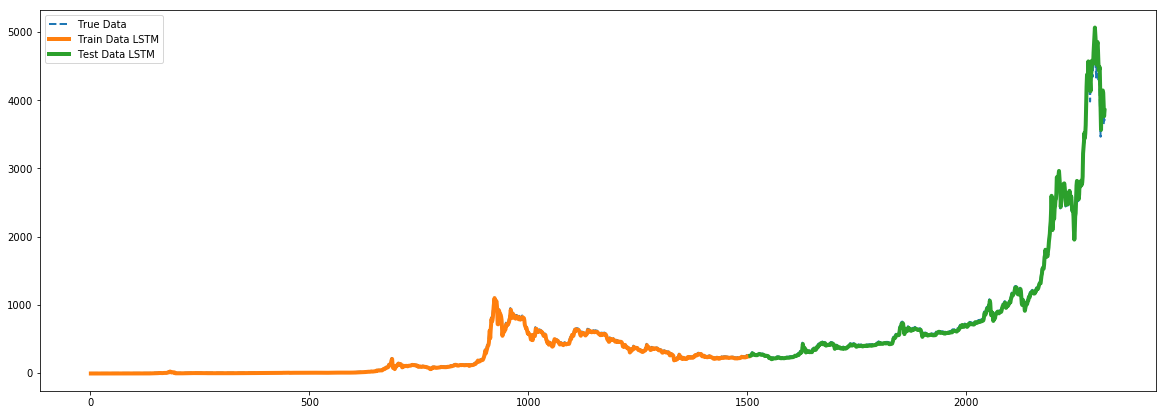

In [29]:
# wyplotowanie danych oryginalnych, treningowych oraz testowych

plt.figure(figsize=(20,7))
plt.plot(scaler.inverse_transform(dataset), label="Line 1", linestyle='--', linewidth=2)
plt.plot(trainPredictPlot, linewidth=4)
plt.plot(testPredictPlot, linewidth=4)
plt.legend(['True Data','Train Data LSTM','Test Data LSTM'] , loc=0)
plt.show()

Po przygotowaniu modelu i sprawdzeniu "jakości predykcji" użyję go do określenia ceny na najbliższe X dni (zakładając gigantyczną zmiennośc rynku sprawdzam 14 dni)

In [30]:
import numpy as np

In [31]:
# predykowanie danych na najlbliższe "length" dni, za pomocą modelu "model" oraz
# przy użyciu zakresu ostatnich danych rzeczywistych "windows_size"

def predict_sequences_multiple(model, window_size, length):
    
    prediction_seqs = []
    curr_frame = window_size  
    predicted = []     
    for i in range(length):     
        predicted.append(model.predict(curr_frame[:,:])[0,0])      
        curr_frame = curr_frame[1:]
        curr_frame = np.insert(curr_frame, i+1, predicted[-1], axis=0)     
        prediction_seqs.append(predicted[-1])
    return prediction_seqs

In [32]:
# wykres ceny dla najbliższych "predicted_length" = x dni

def plot_results_multiple(predicted_data, predict_length):
    
    predictions_LSTM = predict_sequences_multiple(model_LSTM, predicted_data, predict_length)
    predictions_SRNN = predict_sequences_multiple(model_SRNN, predicted_data, predict_length)
    
    plt.figure(figsize=(20,5))
    
    plt.plot(scaler.inverse_transform(np.array(predictions_LSTM).reshape(-1, 1)), linewidth=2, color='b')
    #plt.plot(scaler.inverse_transform(np.array(predictions_SRNN).reshape(-1, 1)), linewidth=2, color='g')
    plt.legend(['Predicted Data LSTM', 'Predicted Data SRNN'] , loc=0)
    plt.show()

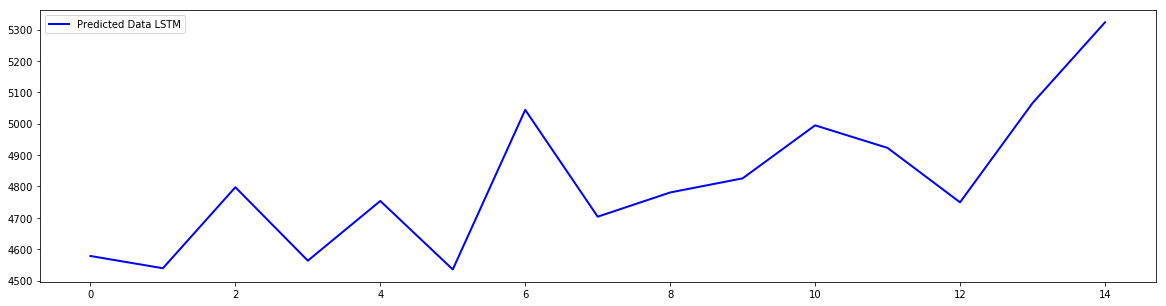

In [33]:
considered_data_window = testX[-30:-1] # ostatnie 20 dni istniejących danych
predict_for_X_days = 15 # dni
plot_results_multiple(considered_data_window, predict_for_X_days)